In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [23]:
# Cell 1: Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import matplotlib.pyplot as plt


In [24]:
# Cell 2: Load the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mumbai House Prices.csv')


In [25]:
# Cell 3: Data Preprocessing
def convert_price(price, unit):
    if unit == 'Cr':
        return price * 10**7  # Convert Cr to actual number
    elif unit == 'L':
        return price * 10**5  # Convert L to actual number
    return price

data['price'] = data.apply(lambda row: convert_price(row['price'], row['price_unit']), axis=1)

# Apply Log Transformation on price (target variable)
data['log_price'] = np.log1p(data['price'])
y = data['log_price']


In [5]:
# # Cell 4: Encode categorical variables
# label_encoder = LabelEncoder()

# # Add 'unknown' category for unseen values
# def add_unknown_category(df, column):
#     df[column] = df[column].astype('category')
#     df[column] = df[column].cat.add_categories('unknown')
#     return df

# data = add_unknown_category(data, 'region')
# data = add_unknown_category(data, 'locality')

# label_encoder_region = LabelEncoder()
# label_encoder_locality = LabelEncoder()

# data['region'] = label_encoder_region.fit_transform(data['region'])
# data['locality'] = label_encoder_locality.fit_transform(data['locality'])


In [26]:
# Add 'unknown' category to LabelEncoder during initialization
def ensure_unknown_in_label_encoder(label_encoder, data_column):
    if 'unknown' not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown')
    return label_encoder

# Add 'unknown' to the categorical variable before encoding
def add_unknown_category(df, column):
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.add_categories('unknown')
    return df

# Updated workflow for encoding
data = add_unknown_category(data, 'region')
data = add_unknown_category(data, 'locality')

# Fit the LabelEncoder
label_encoder_region = LabelEncoder()
label_encoder_region.fit(data['region'])  # Fit with the added 'unknown' category
label_encoder_region = ensure_unknown_in_label_encoder(label_encoder_region, data['region'])

label_encoder_locality = LabelEncoder()
label_encoder_locality.fit(data['locality'])
label_encoder_locality = ensure_unknown_in_label_encoder(label_encoder_locality, data['locality'])

# Transform the data
data['region'] = label_encoder_region.transform(data['region'])
data['locality'] = label_encoder_locality.transform(data['locality'])


In [27]:
# Cell 5: Feature Engineering: Drop irrelevant or less important features
X = data[['area', 'region', 'locality', 'bhk']]

# Check for outliers and remove them using Z-score
z_scores = np.abs(stats.zscore(X))
mask = (z_scores < 3).all(axis=1)
X_no_outliers = X[mask]
y_no_outliers = y[mask]


In [28]:
# Cell 6: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)


In [29]:
# Cell 7: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
# Cell 8: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(n_estimators=50, random_state=42)

In [31]:
# Cell 9: Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model Evaluation:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Random Forest Model Evaluation:
Mean Absolute Error: 0.09938376727330336
Mean Squared Error: 0.03179319530931724
Root Mean Squared Error: 0.17830646457522858
R² Score: 0.9508728585699692


In [11]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_model, 'house_price_model.pkl')

# Save the scaler (for later use)
joblib.dump(scaler, 'scaler.pkl')

# Save the label encoders for region and locality (for later use)
joblib.dump(label_encoder_region, 'label_encoder_region.pkl')
joblib.dump(label_encoder_locality, 'label_encoder_locality.pkl')


['label_encoder_locality.pkl']

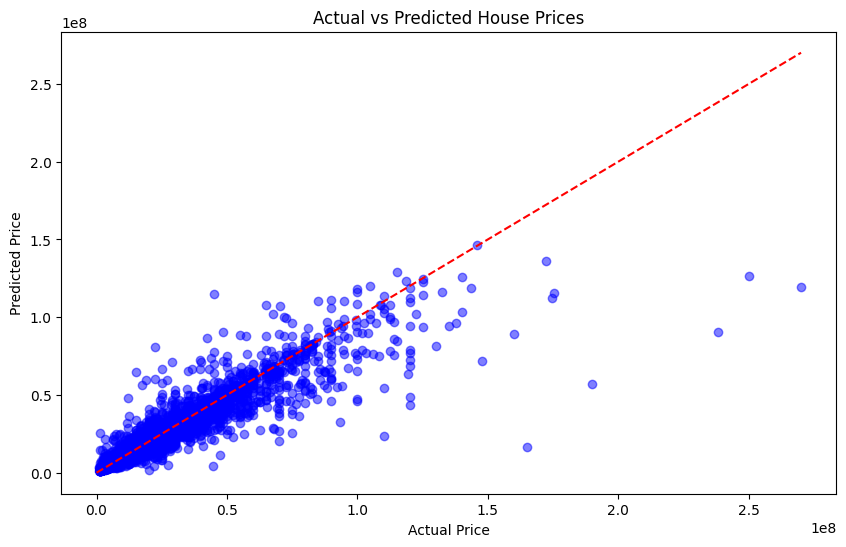

In [32]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Reverse the log transformation on the predictions and true values
y_pred_rf_exp = np.expm1(y_pred_rf)
y_test_exp = np.expm1(y_test)

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred_rf_exp, color='blue', alpha=0.5)
plt.plot([0, max(y_test_exp)], [0, max(y_test_exp)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.show()


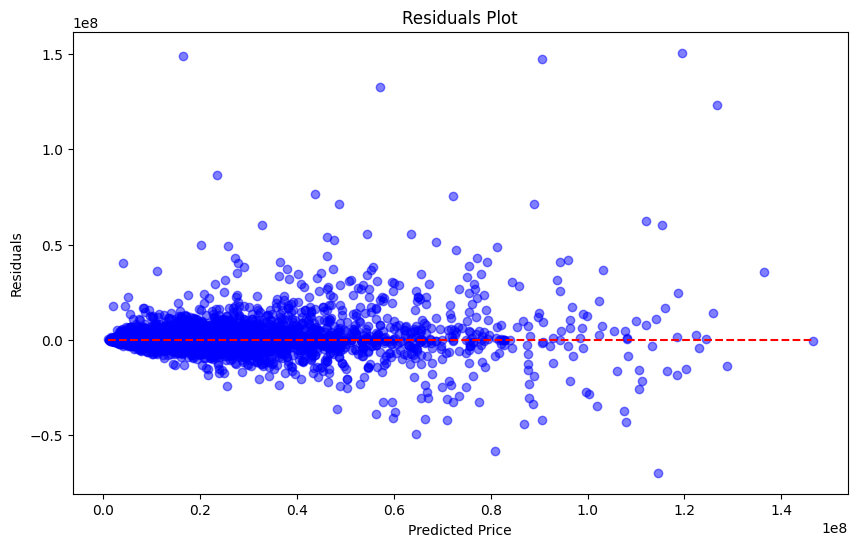

In [33]:
# Residuals plot
residuals = y_test_exp - y_pred_rf_exp

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf_exp, residuals, color='blue', alpha=0.5)
plt.hlines(0, min(y_pred_rf_exp), max(y_pred_rf_exp), colors='red', linestyles='--')  # Line for zero residuals
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


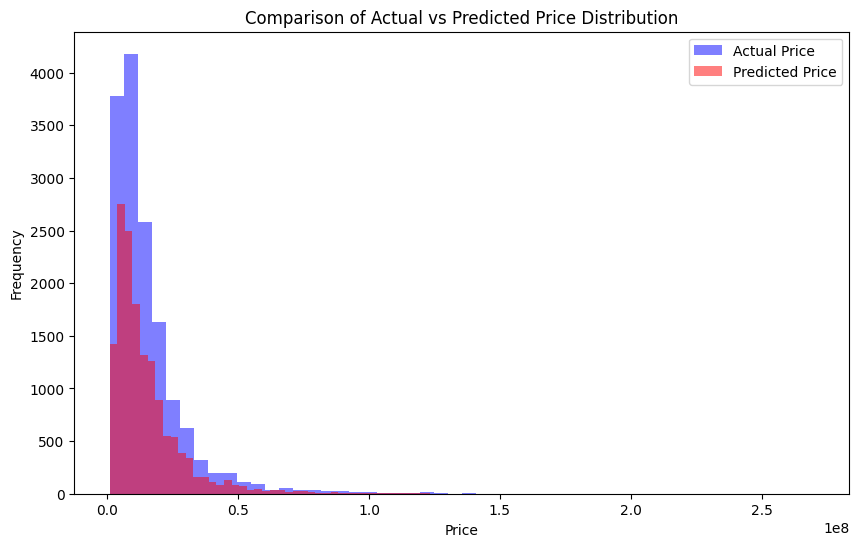

In [34]:
plt.figure(figsize=(10, 6))

# Plot actual price distribution
plt.hist(y_test_exp, bins=50, alpha=0.5, label='Actual Price', color='blue')

# Plot predicted price distribution
plt.hist(y_pred_rf_exp, bins=50, alpha=0.5, label='Predicted Price', color='red')

plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Comparison of Actual vs Predicted Price Distribution')
plt.show()


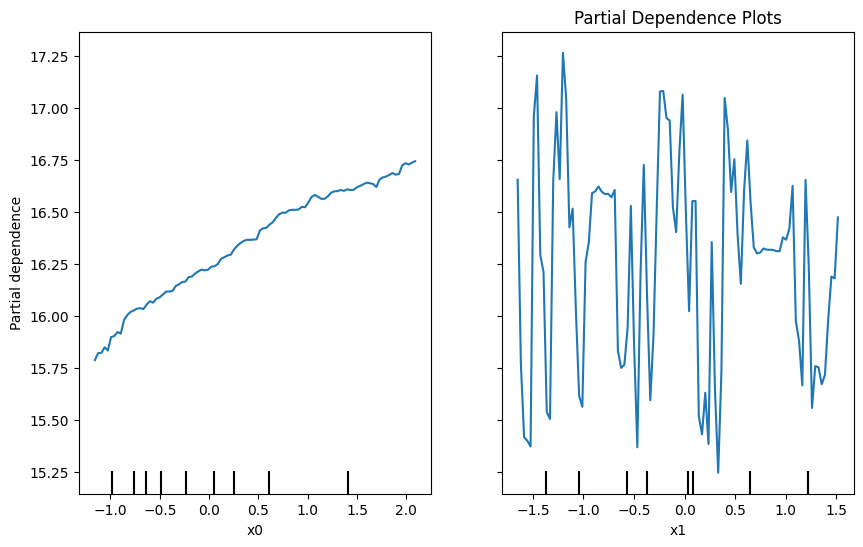

In [37]:
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence for 'area' and 'bhk' features
features = [0, 1]  # Indices of features in your data
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_train_scaled, features=features, ax=ax)
plt.title('Partial Dependence Plots')
plt.show()


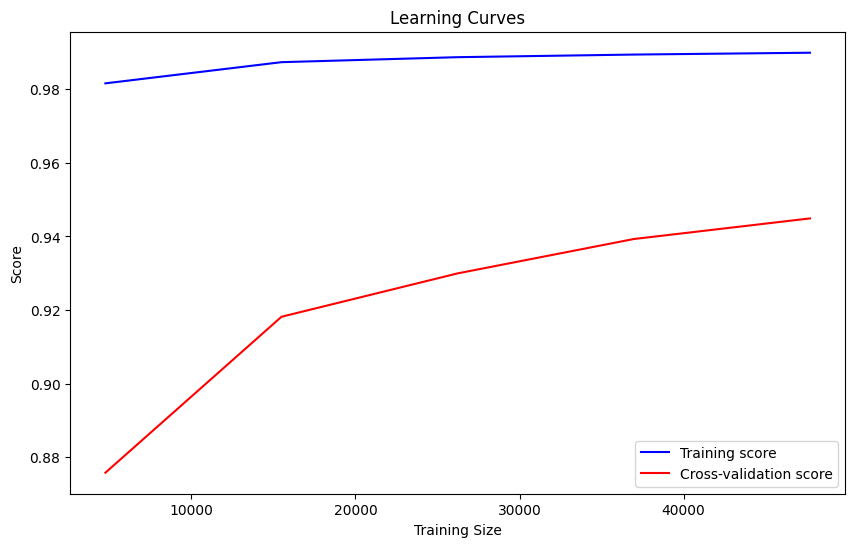

In [38]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train_scaled, y_train, cv=5)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score', color='red')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [36]:
# Cell 10: Function to test the model with user input
def test_model_with_user_input():
    # User input
    area = float(input("Enter the area (in sqft): "))
    bhk = int(input("Enter the number of BHK: "))
    region = input("Enter the region: ").strip()  # Clean extra spaces
    locality = input("Enter the locality: ").strip()  # Clean extra spaces

    # # Check if the region and locality are part of the training data
    # print(f"Region from user input: {region}")
    # print(f"Locality from user input: {locality}")

    # # Check unique values from training set
    # print("Training Regions:", data['region'].unique())
    # print("Training Localities:", data['locality'].unique())

    # Preprocess the input
    if region not in label_encoder_region.classes_:
        region_encoded = label_encoder_region.transform(['unknown'])[0]
    else:
        region_encoded = label_encoder_region.transform([region])[0]

    if locality not in label_encoder_locality.classes_:
        locality_encoded = label_encoder_locality.transform(['unknown'])[0]
    else:
        locality_encoded = label_encoder_locality.transform([locality])[0]

    # print(region_encoded, locality_encoded)

    # Combine input features
    X_input = pd.DataFrame([[area, region_encoded, locality_encoded, bhk]], columns=['area', 'region', 'locality', 'bhk'])

    # Scale the input
    X_input_scaled = scaler.transform(X_input)  # Apply scaling using the fitted scaler

    # Make prediction
    y_pred = rf_model.predict(X_input_scaled)

    # Convert log price back to original price
    predicted_price = np.expm1(y_pred[0])  # Reverse the log transformation
    print(f"Predicted Price: {predicted_price:,.2f}")

# Cell 11: Test with user input
test_model_with_user_input()


Enter the area (in sqft): 550
Enter the number of BHK: 2
Enter the region: Thane West
Enter the locality: Majiwada
Region from user input: Thane West
Locality from user input: Majiwada
Training Regions: [  8 124  31 140 117 141  28 154  15  51  16  93  34  68 205  72 147  55
 194 213  26   2   5  30 217  91 198  78  67 120 136  62 190 151  56 197
  47  86 125  61  79  96   7  41  83 104 208 108  59  40  20  80  76 131
  75  84  57  50 119 130   6   1 134 215  74  88 155 132  81 204  24 157
 185   4 133 148 113 100 196 188  94 128  23  95   9 220 189 191  38  22
  32 192 206 207 107  37 193 126  44 123 153 167 156  85  71 222 139 114
  66  21 212  18 161 171 127 102 165  39 163 186 172  11 214 116  82 150
 177  69 216 115 218  89 175 149  25 166 170 169  19 160 121 219 158 200
  46 135  48 178  64 180 199 184  63 227 101 179 224  97 145 159 146  43
 112 164  73  65  42 176  90  13 168  45 209 195  12  10 143  77 202   3
 142 211 187  98  60 129  27 174 152 183  29  14  87  49  52  17 22